In [8]:
import wget
#url = 'https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'
#wget.download(url)

100% [........................................................................] 28908792 / 28908792

'train.txt'

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import sys
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,confusion_matrix,accuracy_score,precision_score,classification_report,recall_score
pd.set_option("display.max_rows", 20, "display.max_columns", 100)

In [10]:
os.listdir()

['.ipynb_checkpoints', 'dev.txt', 'skimlit.ipynb', 'test.txt', 'train.txt']

# Pre process the data 

In [61]:
'''拆开看我就知道怎么处理'''
df2 = pd.DataFrame()

# 首先按照"###" 把文章分成一块一块的 
nums = []
for num, line in enumerate(lines):
    if line.startswith("###"):
            nums.append(num)
            
nums.append(len(lines))


# 然后把每一块变成df， 装入想要的features
for n in range(len(nums) -1):
    paper = lines[nums[n]: nums[n+1]]
    
    
    df1 = pd.DataFrame()

    rsearch_num = []
    subject = []
    main = []


    rsearch_num.append(paper[0])
    for l in paper[1:-1]:
        l2 = l.split('\t')
        subject.append(l2[0])
        main.append(l2[1])

    df1['research num'] =  rsearch_num* len(main)
    df1['subject'] =  subject
    df1['main'] =  main
    df1['line_number'] =  list(range(len(paper[1:-1])))
    df1['total_lines'] =  len(paper[1:-1])
    
    # 然后再把这些小的df合到一起
    df2 = pd.concat([df2,df1])
    
df2 = df2.reset_index()
df2 = df2[['research num', 'subject', 'main', 'line_number','total_lines']]


In [2]:
'''改成function 因为有多个 text file要处理'''

def Process_textfile(file):
    
    with open(file, "r") as f:
        lines = f.readlines()
    
        df2 = pd.DataFrame()

    # 首先按照"###" 把文章分成一块一块的 
    nums = []
    for num, line in enumerate(lines):
        if line.startswith("###"):
                nums.append(num)

    nums.append(len(lines))


    # 然后把每一块变成df， 装入想要的features
    for n in range(len(nums) -1):
        paper = lines[nums[n]: nums[n+1]]


        df1 = pd.DataFrame()

        rsearch_num = []
        subject = []
        main = []


        rsearch_num.append(paper[0])
        for l in paper[1:-1]:
            l2 = l.split('\t')
            subject.append(l2[0])
            main.append(l2[1])

        df1['research num'] =  rsearch_num* len(main)
        df1['subject'] =  subject
        df1['text'] =  main
        df1['line_number'] =  list(range(len(paper[1:-1])))
        df1['total_lines'] =  len(paper[1:-1])

        # 然后再把这些小的df合到一起
        df2 = pd.concat([df2,df1])

    df2 = df2.reset_index()
    df2 = df2[['research num', 'subject', 'text', 'line_number','total_lines']]

    
    return df2

In [5]:
test_df = Process_textfile('test.txt')
val_df = Process_textfile('dev.txt')
train_df = Process_textfile('train.txt')

len(train_df), len(val_df), len(test_df)

(180040, 30212, 30135)

In [3]:
train_df = Process_textfile('train.txt')

# Data EDA (Exploratory data analysis)

In [4]:
train_df

,research num,subject,text,line_number,total_lines
0,###24293578\n,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,###24293578\n,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,###24293578\n,METHODS,Outcome measures included pain reduction and i...,2,12
3,###24293578\n,METHODS,Pain was assessed using the visual analog pain...,3,12
4,###24293578\n,METHODS,Secondary outcome measures included the Wester...,4,12
...,...,...,...,...,...
180035,###26227186\n,RESULTS,For the absolute change in percent atheroma vo...,7,12
180036,###26227186\n,RESULTS,"For PAV , a significantly greater percentage o...",8,12
180037,###26227186\n,RESULTS,Both strategies had acceptable side effect pro...,9,12
180038,###26227186\n,CONCLUSIONS,"Compared with standard statin monotherapy , th...",10,12


In [5]:
# objects 稍微少一点 
train_df.subject.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: subject, dtype: int64

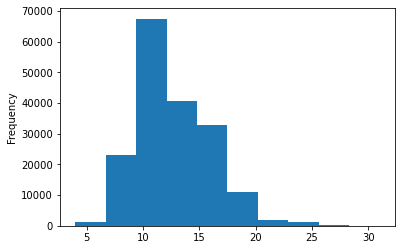

In [75]:
# 看来 10-12个subject的文章最多 
train_df.total_lines.plot.hist();

# Make numeric labels

## Dummies variable (one hot encoding)

In [121]:
num_classes = set(train_df.subject.tolist())
num_classes

{'BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'}

In [11]:
pd.get_dummies(train_df.subject)

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS
0,0,0,0,1,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
180035,0,0,0,0,1
180036,0,0,0,0,1
180037,0,0,0,0,1
180038,0,1,0,0,0


## Label encode labels

In [149]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["subject"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["subject"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["subject"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [146]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [19]:
train_df.subject.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: subject, dtype: int64

In [26]:
from collections import Counter
sorted(Counter(train_labels_encoded).items())

[(0, 21727), (1, 27168), (2, 59353), (3, 13839), (4, 57953)]

In [48]:
sorted(Counter(test_labels_encoded).items())

[(0, 3621), (1, 4571), (2, 9897), (3, 2333), (4, 9713)]

In [21]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Model 0: Getting a baseline （TfidfVectorizer &MultinomialNB） 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("classfier", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_df.text, 
            y=train_labels_encoded);

In [39]:
# Evaluate baseline on validation dataset
model_0.score(X=test_df.text,y=test_labels_encoded)

0.716674962667994

In [40]:
from sklearn.metrics import accuracy_score
ypred = model_0.predict(test_df.text)
accuracy_score(test_labels_encoded,ypred)

0.716674962667994

In [47]:
from sklearn.metrics import classification_report
c = classification_report(test_labels_encoded, ypred, digits = 4,output_dict=True)
c = pd.DataFrame(c).transpose()
c = c.iloc[:-3,:]
c.index = label_encoder.classes_
c

,precision,recall,f1-score,support
BACKGROUND,0.647239,0.466170,0.541981,3621.0
CONCLUSIONS,0.631453,0.577992,0.603541,4571.0
METHODS,0.722620,0.877337,0.792498,9897.0
OBJECTIVE,0.736842,0.126018,0.215227,2333.0
RESULTS,0.758602,0.853495,0.803256,9713.0


## Baseline accuary -> 0.72

# Preparing data from deep learning models

## Prepare the sentence

In [6]:
train_df['sentence_lens'] = train_df['text'].apply(lambda x: len(x.split()))

In [7]:
train_df

,research num,subject,text,line_number,total_lines,sentence_lens
0,###24293578\n,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12,49
1,###24293578\n,METHODS,A total of @ patients with primary knee OA wer...,1,12,27
2,###24293578\n,METHODS,Outcome measures included pain reduction and i...,2,12,15
3,###24293578\n,METHODS,Pain was assessed using the visual analog pain...,3,12,14
4,###24293578\n,METHODS,Secondary outcome measures included the Wester...,4,12,35
...,...,...,...,...,...,...
180035,###26227186\n,RESULTS,For the absolute change in percent atheroma vo...,7,12,95
180036,###26227186\n,RESULTS,"For PAV , a significantly greater percentage o...",8,12,28
180037,###26227186\n,RESULTS,Both strategies had acceptable side effect pro...,9,12,18
180038,###26227186\n,CONCLUSIONS,"Compared with standard statin monotherapy , th...",10,12,30


In [58]:
#平均 26个 单词一句
np.average(train_df['sentence_lens'])

26.338269273494777

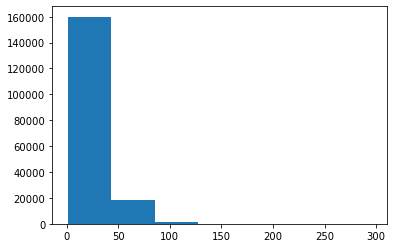

In [59]:
# 大多数都在0-50句
plt.hist(train_df['sentence_lens'], bins=7);

In [61]:
#covers 95% of the lengths
output_seq_len = int(np.percentile(train_df['sentence_lens'], 95))
output_seq_len

55

In [2]:
2.5*2.5

6.25

## Create text level (word) vectorizer

In [8]:
# 总共的词汇量， vocabulary size of the PubMed 20k dataset as 68,000
max_tokens = 68000
train_sentences = train_df['text']

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                                    output_sequence_length=55)

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
Attributable costs and length of stay for each complication were calculated by multiplying the independent cost of each event by its frequency in the treatment group .


Length of text: 27

Vectorized text:
[[ 3289   577     3   523     4   603    11   122  1101     9   757    22
  29957     2   556   608     4   122   675    22   308   400     5     2
     19    13     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [14]:
pd.DataFrame(text_vectorizer.get_vocabulary())

,0
0,
1,[UNK]
2,the
3,and
4,of
...,...
64836,aainduced
64837,aaigroup
64838,aachener
64839,aachen


In [13]:
text_vectorizer.

[array([b'the', b'and', b'of', ..., b'aachener', b'aachen', b'aaacp'],
       dtype=object)]

## Find the most common words in our word level vectorization

In [22]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [23]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Create an Embedding layer 

In [24]:
# Create token embedding layer 相当于是把每个单词每个都转成128维度，比如这句话10个单词就是 10*128
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, 
                               # 意思是告诉 network 这些是padding，不是真正的数字， 所以不需要去计算这些 (update weights)
                               mask_zero=True,
                               name="token_embedding") 

train_sentences = train_df['text']
target_sentence = random.choice(train_sentences)


# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
print(f"vectorization sentence shape: {vectorized_sentence.shape}")

print( )
print('------------')
print( )

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
The top two methods for recruitment were mass mailing followed by email ; together they were cited by @ % of those recruited .


Sentence after vectorization (before embedding):
[[    2  3833    51   578    11   940     9   385 22611   284    22  4281
   2004   316     9 10417    22     4   125   404     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

vectorization sentence shape: (1, 55)

------------

Sentence after embedding:
[[[-0.01555037  0.02877511 -0.00347774 ... -0.03784745  0.03308256
   -0.03672491]
  [-0.03711827  0.01279615 -0.01812196 ...  0.01001102  0.01140619
    0.01739408]
  [-0.03450936  0.00593271 -0.01724952 ...  0.04704529  0.01969621
   -0.01385029]
  ...
  [-0.03125256  0.00108073 -0.02026033 ...  0.0032765  -0.00070886
   -0.03109043]
  [-0.03125256  0.00108073 -0.0

## Create fast loading dataset with the tensorflow tf.data API

In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['text'], pd.get_dummies(train_df.subject)))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_df['text'], pd.get_dummies(val_df.subject)))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['text'], pd.get_dummies(test_df.subject)))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.uint8)>

In [7]:
len(train_df), len(val_df), len(test_df)

(180040, 30212, 30135)

In [37]:
# AUTOTUNE 意思是自动来 how many sample should we prefetch at a time, 这里就是 as much as possible
# 而且这里的数据不用shuffle， 因为 order matters here 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.uint8)>

In [12]:
# len(train_dataset) *32 -> 180064
len(train_dataset),len(valid_dataset),len(test_dataset)

(5627, 945, 942, 180064)

# Model 1: Conv1D with token embeddings

## No shuffle train data

In [40]:
#train_dataset = train_dataset.batch(32).prefetch(3)

num_classes = 5

inputs = tf.keras.layers.Input(shape = (), dtype= tf.string)
text_vectors = text_vectorizer(inputs)
embedding = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same',activation = 'relu')(embedding)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


model1_no_shuffle = tf.keras.Model(inputs, outputs)
model1_no_shuffle.compile(loss = 'categorical_crossentropy', 
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])



model1_no_shuffle.fit(train_dataset,
                      validation_data=valid_dataset,
                      epochs= 3,
                      batch_size = 32,
                      
                      
                      # only take 10% of data, 因为数据量太大了 几十万条text, 这里可以选择多少数据从 training data里面训练
                      steps_per_epoch=int(0.1 * len(train_dataset)),
                      validation_steps=int(0.1 * len(valid_dataset))
                     )
                     


model1_no_shuffle.summary()

Epoch 1/3
562/562 [==============================] - 41s 72ms/step - loss: 0.5559 - accuracy: 0.8078 - val_loss: 0.5704 - val_accuracy: 0.7992
Epoch 2/3
562/562 [==============================] - 41s 73ms/step - loss: 0.3846 - accuracy: 0.8699 - val_loss: 0.5771 - val_accuracy: 0.7972
Epoch 3/3
562/562 [==============================] - 41s 73ms/step - loss: 0.3550 - accuracy: 0.8813 - val_loss: 0.5937 - val_accuracy: 0.7906
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                          

In [143]:
model_1_pred_probs = model1_no_shuffle.predict(valid_dataset)
model_1_pred_probs.argmax(axis = 1)

array([0, 0, 3, ..., 4, 1, 1], dtype=int64)

In [145]:
print(classification_report(val_labels_encoded, model_1_pred_probs.argmax(axis = 1), output_dict = False, digits = 4))

              precision    recall  f1-score   support

           0     0.6104    0.5741    0.5917      3449
           1     0.6914    0.7124    0.7017      4582
           2     0.8667    0.8687    0.8677      9964
           3     0.6027    0.5619    0.5816      2376
           4     0.8492    0.8668    0.8579      9841

    accuracy                         0.7866     30212
   macro avg     0.7241    0.7168    0.7201     30212
weighted avg     0.7844    0.7866    0.7853     30212



In [147]:
print('classification report:')
c = classification_report(val_labels_encoded, model_1_pred_probs.argmax(axis = 1), digits = 4,output_dict=True)
c = pd.DataFrame(c).transpose()
c = c.iloc[:-3,:]
c.index = label_encoder.classes_
c

classification report:


,precision,recall,f1-score,support
BACKGROUND,0.610358,0.574079,0.591663,3449.0
CONCLUSIONS,0.691379,0.712353,0.701709,4582.0
METHODS,0.866727,0.868727,0.867726,9964.0
OBJECTIVE,0.602709,0.561869,0.581573,2376.0
RESULTS,0.849179,0.866782,0.857890,9841.0


In [151]:
label_encoder.inverse_transform([0])

array(['BACKGROUND'], dtype=object)

### Model 1 no shuffle accuary -> 0.786

## Shuffle train data

In [153]:
# shuffle the traning dataset
train_df = train_df.sample(len(train_df))


# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['text'], pd.get_dummies(train_df.subject)))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_df['text'], pd.get_dummies(val_df.subject)))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['text'], pd.get_dummies(test_df.subject)))

# put data into batch 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# model
inputs = tf.keras.layers.Input(shape = (1,), dtype= tf.string)
text_vectors = text_vectorizer(inputs)
embedding = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same',activation = 'relu')(embedding)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(len(num_classes), activation = 'softmax')(x)


model1_shuffle = tf.keras.Model(inputs, outputs)
model1_shuffle.compile(loss = 'categorical_crossentropy', 
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])



model1_shuffle.fit(train_dataset,
                   validation_data=valid_dataset,
                   epochs= 3,

                   # only take 10% of data, 因为数据量太大了 几十万条text 
                   steps_per_epoch=int(0.1 * len(train_dataset)),
                   validation_steps=int(0.1 * len(valid_dataset))
                   )
                     


model1_shuffle.summary()

Epoch 1/3
562/562 [==============================] - 31s 55ms/step - loss: 0.6627 - accuracy: 0.7614 - val_loss: 0.5857 - val_accuracy: 0.7896
Epoch 2/3
562/562 [==============================] - 41s 74ms/step - loss: 0.5507 - accuracy: 0.8018 - val_loss: 0.5731 - val_accuracy: 0.7919
Epoch 3/3
562/562 [==============================] - 38s 68ms/step - loss: 0.5436 - accuracy: 0.8106 - val_loss: 0.5704 - val_accuracy: 0.7965
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                          

### Model 1 shuffle accuary -> 0.7965

# Model 2: transfer learning model 

In [76]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [158]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_df['text'])
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{use_embedded_sentence[0].shape}")

Random training sentence:
A comparison of the screening rates will then take place , using the faecal occult blood test of the patients from the control and the intervention groups .


Sentence after embedding:
[-0.04340596 -0.00410624  0.04453267 -0.02551643  0.00866798 -0.04148094
  0.07219423 -0.03838151 -0.05621168 -0.00078156  0.09520157  0.04321394
  0.04750543  0.03999333 -0.03068188 -0.01753978 -0.09501836 -0.06980894
 -0.07800989  0.05257524 -0.03943029  0.02266692 -0.08308131 -0.01921579
  0.05804289 -0.05223611 -0.06536747  0.07417352  0.04150463  0.01932045] (truncated output)...

Length of sentence embedding:
(512,)


In [43]:
# functional API + trainable=False

print(len(train_dataset))


inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x) # create the output layer

model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.fit(train_dataset,
            validation_data=valid_dataset,
            epochs = 3,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            validation_steps=int(0.1 * len(valid_dataset)),
           )


model_2.summary()

5627
Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 0.9210 - accuracy: 0.6481 - val_loss: 0.8010 - val_accuracy: 0.6835
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.7748 - accuracy: 0.6998 - val_loss: 0.7577 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.7565 - accuracy: 0.7117 - val_loss: 0.7423 - val_accuracy: 0.7144
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                           

In [44]:
# sequential API
# trainable=True 太慢 所以关掉了



print(len(train_dataset))

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=True,
                                        input_shape=[], 
                                        dtype=tf.string,
                                        name="universal_sentence_encoder")

model22 = tf.keras.Sequential([
    tf_hub_embedding_layer,

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])
model22.compile(loss ='categorical_crossentropy', 
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics =['accuracy'])


model22.fit(train_dataset,
            validation_data=valid_dataset,
            epochs = 3,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            validation_steps=int(0.1 * len(valid_dataset)),
           batch_size = 32)

    



print(model22.summary())

5627
Epoch 1/3
227/562 [===========>..................] - ETA: 6:04 - loss: 0.9370 - accuracy: 0.6322

KeyboardInterrupt: 

## Model2 transfer learning -> 0.71

# Model 3: Conv1D with character embeddings

In [45]:
def split_chars(text):
      return " ".join(list(text))

    
random_training_sentence =  train_df['text'].sample(1).tolist()[0]
# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'T h e s e   p a t i e n t s   w e r e   c o m p a r e d   w i t h   @   c o n v e n t i o n a l l y   t r e a t e d   p a t i e n t s   w i t h   P C   . \n'

In [12]:
list(random_training_sentence)

['T',
 'h',
 'i',
 'r',
 'd',
 ' ',
 ',',
 ' ',
 'w',
 'e',
 ' ',
 'i',
 'n',
 'c',
 'l',
 'u',
 'd',
 'e',
 'd',
 ' ',
 'a',
 ' ',
 'c',
 'o',
 'm',
 'p',
 'r',
 'e',
 'h',
 'e',
 'n',
 's',
 'i',
 'v',
 'e',
 ' ',
 'p',
 'r',
 'o',
 'c',
 'e',
 's',
 's',
 ' ',
 'e',
 'v',
 'a',
 'l',
 'u',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 't',
 'o',
 ' ',
 'r',
 'a',
 'i',
 's',
 'e',
 ' ',
 'e',
 'x',
 't',
 'e',
 'r',
 'n',
 'a',
 'l',
 ' ',
 'v',
 'a',
 'l',
 'i',
 'd',
 'i',
 't',
 'y',
 ' ',
 '.',
 '\n']

## Crate train, test , validation character 

In [47]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_df['text']]
val_chars = [split_chars(sentence) for sentence in val_df['text']]
test_chars = [split_chars(sentence) for sentence in test_df['text']]

len(train_chars)

180040

In [42]:
train_chars[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   . \n'

In [41]:
# example - the len of a string， 空格这些都算所以这个列子就算9个caracters 
len('haha haha')

9

In [44]:
# 求的是平均句子的 caracters 个数
anp.mean([len(i) for i in train_df['text']])

150.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([   2.        ,  199.85714286,  397.71428571,  595.57142857,
         793.42857143,  991.28571429, 1189.14285714, 1387.        ]),
 <BarContainer object of 7 artists>)

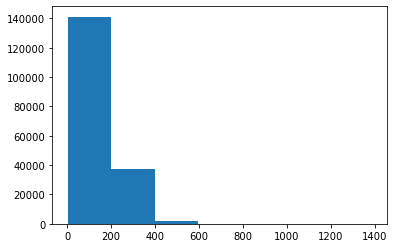

In [49]:
char_lens = [len(i) for i in train_df['text']]

plt.hist(char_lens, bins=7)

In [50]:
# 需要大概cover 95%的 data 
character_len = int(np.percentile(char_lens, 95))
character_len

291

## Create caracter level vectorizer 

In [51]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [52]:

max_tokens = len(alphabet)
train_sentences = train_df['text']

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

character_vectorizer = TextVectorization(max_tokens=max_tokens, 
                                    output_sequence_length=character_len)

# Adapt text vectorizer to training sentences
character_vectorizer.adapt(train_chars)

# Test out text vectorizer
import random
target_sentence = random.choice(train_chars)
print(f"Orignal Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f'\nVectorized chars:\n{character_vectorizer([target_sentence])}')
print(f"\nLength of vectorized chars: {len(character_vectorizer([target_sentence])[0])}")

Orignal Text:
E x e r c i s e   d e c r e a s e d   c r a v i n g   r e l a t i v e   t o   b a s e l i n e   f o r   c r a v i n g   b a s e d   o n   b o t h   t h e   p l e a s u r a b l e   c o n s e q u e n c e s   o f   s m o k i n g   (   D   =   - @   o n   a   @ - p o i n t   v i s u a l   a n a l o g   s c a l e   )   a n d   a n t i c i p a t e d   r e l i e f   f r o m   w i t h d r a w a l   (   D   =   - @   )   ,   w h e r e a s   i n a c t i v i t y   i n c r e a s e d   b o t h   c o m p o n e n t s   o f   c r a v i n g   (   D s   =   @   a n d   @   )   . 


Length of text: 569

Vectorized chars:
[[ 2 24  2  8 11  4  9  2 10  2 11  8  2  5  9  2 10 11  8  5 21  4  6 18
   8  2 12  5  3  4 21  2  3  7 22  5  9  2 12  4  6  2 17  7  8 11  8  5
  21  4  6 18 22  5  9  2 10  7  6 22  7  3 13  3 13  2 14 12  2  5  9 16
   8  5 22 12  2 11  7  6  9  2 26 16  2  6 11  2  9  7 17  9 15  7 23  4
   6 18 10  7  6  5 14  7  4  6  3 21  4  9 16  5 12  5  6  5 12  7 18  9
  11  

In [116]:
#找最长的这句话 
train_df[train_df['sentence_lens'] == train_df['sentence_lens'].max()]

,research num,subject,text,line_number,total_lines,sentence_lens
122524,###25502343\n,RESULTS,Patients in the antegrade group achieved bette...,8,17,296


In [118]:
# 291个 caracter 长度全部装满了
character_vectorizer([train_chars[122524]])

<tf.Tensor: shape=(1, 291), dtype=int64, numpy=
array([[14,  5,  3,  4,  2,  6,  3,  9,  4,  6,  3, 13,  2,  5,  6,  3,
         2, 18,  8,  5, 10,  2, 18,  8,  7, 16, 14,  5, 11, 13,  4,  2,
        21,  2, 10, 22,  2,  3,  3,  2,  8,  7, 16,  3, 11,  7, 15,  2,
         9,  3, 13,  5,  6, 14,  5,  3,  4,  2,  6,  3,  9,  4,  6,  3,
        13,  2,  8,  2,  3,  8,  7, 18,  8,  5, 10,  2, 18,  8,  7, 16,
        14, 17,  7,  8,  5, 12, 12, 11, 12,  4,  6,  4, 11,  5, 12, 14,
         5,  8,  5, 15,  2,  3,  2,  8,  9,  5,  3, 15,  7,  6,  3, 13,
         9, 14,  7,  9,  3,  7, 14,  2,  8,  5,  3,  4, 21,  2, 12, 19,
         8,  7, 15,  5,  6,  3,  2, 18,  8,  5, 10,  2, 15,  2, 10,  4,
         5,  6, 12,  9, 22,  8,  5,  6, 18,  2,  8,  9, 22, 21,  2,  8,
         9, 16,  9,  8,  2,  3,  8,  7, 18,  8,  5, 10,  2, 12,  9, 22,
         8,  5,  6, 18,  2,  8,  9, 22, 10,  4, 17, 17,  2,  8,  2,  6,
        11,  2,  7, 17, 15,  2, 10,  4,  5,  6,  9, 14, 21,  5,  9,  5,
         6,  3, 

In [95]:
# 可以看出所有的 标点符号和 空格是不算的 是不会被 vectorized 的
character_vectorizer(['m y n a m e i s k ! @'])

<tf.Tensor: shape=(1, 291), dtype=int64, numpy=
array([[15, 19,  6,  5, 15,  2,  4,  9, 23,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

## Find out the most characters level vector in the house

In [54]:
# 空格和 unk都算是 characters， 可以看出 特殊字符那些都被移走了 
char_vocab = character_vectorizer.get_vocabulary()

print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")
char_vocab

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

## Find out the most characters level vector with standardize on

In [99]:
# 意思是当  standardize = None 这些特殊字符标点符号都要算进去了 成为一个 vector , 这样算下来的 character就有68个

max_tokens = len(alphabet)
train_sentences = train_df['text']

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

character_vectorizer_standardize_none = TextVectorization(max_tokens=max_tokens, 
                                         output_sequence_length=character_len,
                                         #standardize="lower_and_strip_punctuation" # default
                                         standardize = None)


character_vectorizer_standardize_none.adapt(train_chars)

char_vocab_standardize_none = character_vectorizer_standardize_none.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab_standardize_none)}")
print(f"5 most common characters: {char_vocab_standardize_none[:5]}")
print(f"5 least common characters: {char_vocab_standardize_none[-5:]}")
char_vocab_standardize_none

Number of different characters in character vocab: 68
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['+', 'X', '`', '>', 'J']


['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'l',
 'c',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 '@',
 'y',
 'w',
 'v',
 'b',
 ',',
 '.',
 '-',
 ')',
 '(',
 'T',
 'S',
 'C',
 'P',
 'A',
 'I',
 'k',
 'x',
 'R',
 '%',
 'B',
 'D',
 'L',
 'M',
 'z',
 '=',
 'E',
 'H',
 'F',
 'N',
 'O',
 '/',
 ';',
 'q',
 'V',
 'G',
 'j',
 'W',
 ':',
 '<',
 'U',
 "'",
 'Q',
 'K',
 '+',
 'X',
 '`',
 '>',
 'J']

In [119]:
# 这个时候后面的2个标点符号就被 vectorized 的
character_vectorizer_standardize_none(['m y n a m e i s k ! @'])

<tf.Tensor: shape=(1, 291), dtype=int64, numpy=
array([[15, 20,  6,  5, 15,  2,  4,  9, 35,  1, 19,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

## Create a character-level embedding

In [55]:
# Create char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab), 
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
example = random.choice(train_chars)
example = 'h a h a h a h a'
print(f"Charified text (before vectorization and embedding):\n{example}\n")

# 变成vector的效果
print(f'Vectorized chars:\n{character_vectorizer([example])}\n')
print(f'len of Vectorized chars: \n{character_vectorizer([example]).shape}\n')
# 从 vector 又加上一层 embdedding
char_embed_example = char_embed(character_vectorizer([example]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
h a h a h a h a

Vectorized chars:
[[13  5 13  5 13  5 13  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]]

len of Vec

## Build a Conv1D model to fit on character embeddings

### GlobalAveragePooling1D -> 0.46

In [59]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, pd.get_dummies(train_df.subject))).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, pd.get_dummies(val_df.subject))).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, pd.get_dummies(test_df.subject))).batch(32).prefetch(tf.data.AUTOTUNE)


print(len(train_char_dataset))
# Create model
inputs = tf.keras.layers.Input(shape=[], dtype= 'string')
char_vectorizer_layer = character_vectorizer(inputs)
char_embedding_layer= char_embed(char_vectorizer_layer)

x = tf.keras.layers.Conv1D(64,kernel_size = 5, padding = 'same', activation = 'relu')(char_embedding_layer)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)),
                             )



model_3.summary()

5627
Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.4636 - accuracy: 0.3473 - val_loss: 1.4104 - val_accuracy: 0.3983
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3687 - accuracy: 0.4242 - val_loss: 1.3354 - val_accuracy: 0.4425
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3273 - accuracy: 0.4518 - val_loss: 1.3201 - val_accuracy: 0.4365
Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 291)              0         
 ectorization)                                                   
                                                                 
 char_embed (Embedding)      (None, 291, 25)           700       
     

### GlobalMaxPooling1D -> 0.60

In [169]:

# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, pd.get_dummies(train_df.subject))).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, pd.get_dummies(val_df.subject))).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, pd.get_dummies(test_df.subject))).batch(32).prefetch(tf.data.AUTOTUNE)

# Create model
inputs = tf.keras.layers.Input(shape=[], dtype= 'string')
char_vectorizer_layer = character_vectorizer(inputs)
char_embedding_layer= char_embed(char_vectorizer_layer)

x = tf.keras.layers.Conv1D(64,kernel_size = 5, padding = 'same', activation = 'relu')(char_embedding_layer)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)),
                              batch_size = 32)



model_3.summary()

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 1.2498 - accuracy: 0.4869 - val_loss: 1.1281 - val_accuracy: 0.5293
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 1.0974 - accuracy: 0.5530 - val_loss: 1.0453 - val_accuracy: 0.5745
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 1.0278 - accuracy: 0.5904 - val_loss: 0.9826 - val_accuracy: 0.6057
Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization_11 (Text  (None, 291)              0         
 Vectorization)                                                  
                                                                 
 char_embed (Embedding)      (None, 291, 25)           700       
          

In [176]:
pred = model_3.predict(val_char_dataset)
len(pred),pred.argmax(axis = 1)

(30212, array([3, 3, 3, ..., 4, 2, 1], dtype=int64))

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

## Build the multi inputs model 

In [90]:
from tensorflow.keras import layers

'''#1 Create a token level embedding (tensorflow hub layer)'''
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)


'''#2 Create a character level model (character level embedding & )'''
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = character_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# copy 论文上的model - bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)



'''#3 Create tf concatenate layer (combine 1 & 2 token - embedding & character embedding)'''
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])



'''#4 Create output layer with dropout '''
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)



'''#5 Construct the model'''
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


'''#6 Compile the model'''
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])




'''#7 Make the model datasets (token + characters) & label'''
# Combine chars and tokens into a dataset 前面是 token level， 后面是 character level 不要放错顺序
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_df['text'], train_chars)) 
train_char_token_labels = tf.data.Dataset.from_tensor_slices(pd.get_dummies(train_df.subject)) 
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_df['text'], val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(pd.get_dummies(val_df.subject))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Check out training char and token embedding dataset
print(train_char_token_dataset, val_char_token_dataset)

'''#8 Fit the model'''
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))








# summary of the model 
model_4.summary()

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.uint8)> <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.uint8)>
Epoch 1/3
562/562 [==============================] - 108s 184ms/step - loss: 0.9934 - accuracy: 0.6000 - val_loss: 0.7907 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 99s 176ms/step - loss: 0.8110 - accuracy: 0.6838 - val_loss: 0.7269 - val_accuracy: 0.7184
Epoch 3/3
562/562 [==============================] - 88s 157ms/step - loss: 0.7930 - accuracy: 0.6978 - val_loss: 0.7079 - val_accuracy: 0.7317
Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                         

## accuracy -> 0.73

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [112]:
train_df.head(13)

,research num,subject,text,line_number,total_lines
0,###24293578\n,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,###24293578\n,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,###24293578\n,METHODS,Outcome measures included pain reduction and i...,2,12
3,###24293578\n,METHODS,Pain was assessed using the visual analog pain...,3,12
4,###24293578\n,METHODS,Secondary outcome measures included the Wester...,4,12
5,###24293578\n,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,12
6,###24293578\n,RESULTS,There was a clinically relevant reduction in t...,6,12
7,###24293578\n,RESULTS,The mean difference between treatment arms ( @...,7,12
8,###24293578\n,RESULTS,"Further , there was a clinically relevant redu...",8,12
9,###24293578\n,RESULTS,These differences remained significant at @ we...,9,12


## Every sentence has a subject (每一个句子都是有主题的)

In [98]:
#这里是one hot line number 其实还可以 onehot subject 节约metrix
train_df['text'][1]

'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n'

## Dummy the line numbers per research paper (Tensorflow one hot)

In [104]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
      ...  
26        7
27        4
28        3
29        1
30        1
Name: line_number, Length: 31, dtype: int64

<AxesSubplot:ylabel='Frequency'>

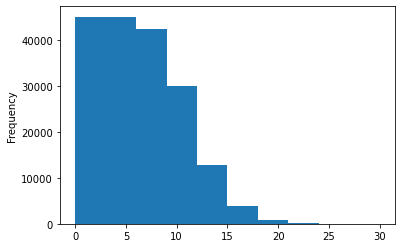

In [105]:
# cut off at 15 , 我们可以保留大部分的信息
train_df.line_number.plot.hist()

In [106]:
dummy_line_num = pd.get_dummies(train_df.line_number,)
dummy_line_num

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180035,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
180036,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
180037,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
180038,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
#这里是one hot line number 其实还可以 onehot subject 节约metrix

dummy_line_num_train = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
dummy_line_num_val = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
dummy_line_num_train

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## Dummy the total lines per research paper (Tensorflow one hot)

(<AxesSubplot:>, 19.0)

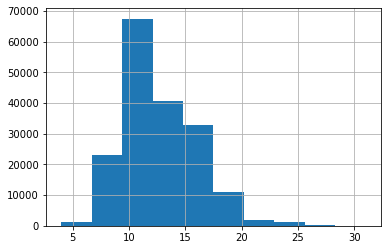

In [117]:
# 选20就可以了
train_df['total_lines'].hist(),np.percentile(train_df.total_lines,95)

In [121]:
dummy_total_line_train = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
dummy_total_line_vali = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
dummy_total_line_test = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

## Make the tribrid model 

In [126]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = character_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [127]:
model_5.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 291)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

## Complie the tribird model with label_smoothing 

In [146]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Create the data input for the tribird model 

In [131]:
# 这里需要注意的是 input order要和 model inputs顺序一样
'''
1. line_number_model.input,
2. total_line_model.input,
3. token_model.input, 
4. char_model.input,
'''       






# Create training datasets (all four kinds of inputs)
train_position_charactor_token_dataset = tf.data.Dataset.from_tensor_slices((dummy_line_num_train, # line numbers
                                                                dummy_total_line_train, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars

# create traning label
train_position_charactor_token_labels = tf.data.Dataset.from_tensor_slices(pd.get_dummies(train_df.subject)) # train labels


# zip train dataset & label together 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_position_charactor_token_dataset, train_position_charactor_token_labels)) 

# batch and prefetch as much as possible data
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
train_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.uint8)>

In [143]:
# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((dummy_line_num_val,
                                                              dummy_total_line_vali,
                                                              val_df.text,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(pd.get_dummies(val_df.subject))
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
val_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.uint8)>

## Fit the tribird model

In [147]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              
                              # 仅仅用了 10%的off data to training， 如果是所有的data 那么准确率会更高
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 91s 151ms/step - loss: 1.1004 - accuracy: 0.7172 - val_loss: 0.9830 - val_accuracy: 0.8072
Epoch 2/3
562/562 [==============================] - 105s 187ms/step - loss: 0.9690 - accuracy: 0.8137 - val_loss: 0.9521 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 104s 186ms/step - loss: 0.9518 - accuracy: 0.8223 - val_loss: 0.9398 - val_accuracy: 0.8318


## Accuracy -> 0.83

In [153]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 46s 48ms/step


array([[0.50036097, 0.08651903, 0.01511671, 0.3792464 , 0.01875687],
       [0.5509153 , 0.09670322, 0.04211105, 0.2995703 , 0.01070011],
       [0.34833878, 0.1067544 , 0.15623432, 0.3208436 , 0.06782896],
       ...,
       [0.0341695 , 0.11025728, 0.04063736, 0.02579984, 0.78913605],
       [0.02791951, 0.30305544, 0.07454214, 0.02399205, 0.5704909 ],
       [0.3049435 , 0.50846285, 0.07934643, 0.0423336 , 0.06491362]],
      dtype=float32)

In [154]:
model_5_pred_probs.argmax(axis = 1)

array([0, 0, 0, ..., 4, 4, 1], dtype=int64)

# Save the best model 

In [155]:
model_5.save("skimlit_tribrid_model2") 

INFO:tensorflow:Assets written to: skimlit_tribrid_model2\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model2\assets


In [152]:
bestmodel = tf.keras.models.load_model('skimlit_tribrid_model')
bestmodel

ValueError: Exception encountered when calling layer "forward_lstm_6" (type LSTM).

The mask that was passed in was tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64)), which cannot be applied to RaggedTensor inputs. Please make sure that there is no mask injected by upstream layers.

Call arguments received:
  • inputs=tf.RaggedTensor(values=Tensor("Placeholder:0", shape=(None, 25), dtype=float32), row_splits=Tensor("Placeholder_1:0", shape=(None,), dtype=int64))
  • mask=tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64))
  • training=None
  • initial_state=None

In [2]:
20+19+18+18+18+18

111